# 🧠 Regression Preprocessing Pipeline

This notebook outlines a detailed, modular approach to preprocessing data for regression models. It includes best practices, statistical reasoning, and alternatives at each stage.


## 1. Data Understanding & Initial Profiling


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2635 entries, 0 to 2634
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Datetime    2635 non-null   object 
 1   MarginalES  2635 non-null   float64
dtypes: float64(1), object(1)
memory usage: 41.3+ KB


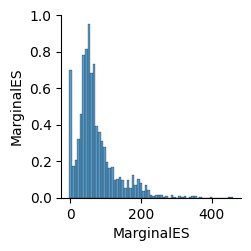

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('../../data/hour_14_metrics.csv')

# Basic info
df.info()
df.describe()

# Visual inspection
sns.pairplot(df)  # Subset for speed if large


### Alternatives:
- Use `pandas_profiling.ProfileReport(df)`
- Use `dtale.show(df)`


## 2. Target Variable Analysis


In [1]:
from scipy.stats import skew, boxcox
import numpy as np

target = df['target_variable']

# Skewness check
print("Skew:", skew(target))

# Optional transformation
target_log = np.log1p(target)  # for positive skew


NameError: name 'df' is not defined

## 3. Missing Value Handling

In [ ]:
# Check for missing
missing_summary = df.isnull().mean().sort_values(ascending=False)

# Imputation example
df.fillna(df.median(), inplace=True)  # Fast, but basic

# Alternative: KNN imputer
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

## 4. Outlier Detection & Treatment

In [9]:
# IQR method
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Optional: Isolation Forest
from sklearn.ensemble import IsolationForest
clf = IsolationForest(contamination=0.01)
df['anomaly'] = clf.fit_predict(df)
df = df[df['anomaly'] == 1].drop(columns='anomaly')


TypeError: unsupported operand type(s) for -: 'str' and 'str'

## 5. Feature Transformation & Scaling


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(columns='target_variable'))


## 6. Feature Engineering


In [ ]:
# Example: Lag features
df['feature_lag1'] = df['feature'].shift(1)

# Example: Rolling mean
df['rolling_mean'] = df['feature'].rolling(window=3).mean()


## 7. Multicollinearity Check


In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df.drop(columns='target_variable')
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["feature"] = X.columns
vif.sort_values('VIF', ascending=False)


ModuleNotFoundError: No module named 'statsmodels'

## 8. Categorical Encoding


In [12]:
# One-hot encoding
df = pd.get_dummies(df, columns=['categorical_feature'])

# Target encoding
# Use with caution — wrap in CV or custom transformer


KeyError: "None of [Index(['categorical_feature'], dtype='object')] are in the [columns]"

## 9. Feature Selection


In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

X = df.drop(columns='target_variable')
y = df['target_variable']
selector = SelectKBest(score_func=f_regression, k=10)
X_selected = selector.fit_transform(X, y)


## 10. Train-Test Split


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42)

# For time series: use TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)


## ✅ Summary & Next Steps

- Use `Pipeline` to wrap and automate preprocessing steps
- Cache results with `joblib`
- Apply model with cross-validation


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', LinearRegression())
])

cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2')
print("Cross-validated R²:", cv_scores.mean())
